# Proyek: Movies Recommendation

Nama: : Jessica Theresia<br>
Email: : me.jessicatheresia@gmail.com<br>
ID Dicoding: : jessica_trs<br>

# Import Library

In [1]:
# Instal dependency
!pip install kagglehub[pandas-datasets]

Pengimporan pustaka yang relevan untuk mendukung pipeline end-to-end, mulai dari pemrosesan data hingga pengembangan model.

In [2]:
# Install library

# from google.colab import drive #matikan ketika running di environment kaggle
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.callbacks import EarlyStopping
import random
from IPython.display import display
import joblib
import pickle
from collections import defaultdict

2025-05-30 00:58:44.774765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748566725.007884      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748566725.070965      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Data

Sumber dataset : https://www.kaggle.com/datasets/parasharmanas/movie-recommendation-system

In [3]:
# Gunakan jika menjalankan di jupyter notebook/GColab/sejenisnya
# # Mount Google Drive
# drive.mount('/content/drive')

In [4]:
# # Memuat dataset
# movies_df = pd.read_csv("/content/drive/MyDrive/Dicoding ML Submission/ML Terapan/Movie_Recommendation_System/movies.csv") #sesuaikan

# ratings_df = pd.read_csv("/content/drive/MyDrive/Dicoding ML Submission/ML Terapan/Movie_Recommendation_System/ratings.csv") #sesuaikan

In [5]:
# Gunakan Jika menjalankan di Kaggle environtment secara langsung

# Memuat file movies.csv
movies_df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "parasharmanas/movie-recommendation-system",
    "movies.csv"
)

# Memuat file ratings.csv
ratings_df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "parasharmanas/movie-recommendation-system",
    "ratings.csv"
)

/tmp/ipykernel_35/3723772177.py:4: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  movies_df = kagglehub.load_dataset(
/tmp/ipykernel_35/3723772177.py:11: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  ratings_df = kagglehub.load_dataset(


# Data Understanding

Dataset yang dimuat terdiri dari dua bagian utama:
- movies.csv dengan 62423 data
- ratings.csv. dengan 25000095 data

movies.csv terdiri dari kolom:

- movieId: ID unik tiap film.
- title: Judul lengkap film beserta tahun rilis.
- genres: Kombinasi genre film, dipisahkan dengan tanda |.

ratings.csv terdiri dari kolom:

- userId: ID unik pengguna.
- movieId: ID film yang dirating.
- rating: Nilai rating (dalam skala desimal).
- timestamp: Waktu rating dalam format UNIX epoch.

In [6]:
print(movies_df.info())
print(ratings_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB
None


In [7]:
# Dari movies_df
print("Jumlah film:", movies_df['movieId'].nunique())
print("Jumlah judul unik:", movies_df['title'].nunique())
print("Jumlah kombinasi genre unik:", movies_df['genres'].nunique())

# Dari ratings_df
print("Jumlah user unik:", ratings_df['userId'].nunique())
print("Jumlah film yang diberi rating:", ratings_df['movieId'].nunique())
print("Jumlah rating total:", ratings_df.shape[0])
print("Rating unik yang tersedia:", ratings_df['rating'].nunique())

Jumlah film: 62423
Jumlah judul unik: 62325
Jumlah kombinasi genre unik: 1639
Jumlah user unik: 162541
Jumlah film yang diberi rating: 59047
Jumlah rating total: 25000095
Rating unik yang tersedia: 10


In [8]:
print("Informasi movies.csv")
print(movies_df.head())

Informasi movies.csv
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [9]:
print("\nInformasi ratings.csv")
print(ratings_df.info())
print(ratings_df.head())


Informasi ratings.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB
None
   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510


# Exploratory Data Analysis (EDA)

## Checking Duplicate Data

In [10]:
# Cek duplikat di movies_df
movies_duplicates = movies_df.duplicated().sum()
print(f"Jumlah duplikat baris di movies_df: {movies_duplicates}")

# Cek duplikat di ratings_df
ratings_duplicates = ratings_df.duplicated().sum()
print(f"Jumlah duplikat baris di ratings_df: {ratings_duplicates}")

Jumlah duplikat baris di movies_df: 0
Jumlah duplikat baris di ratings_df: 0


## Checking Missing Value

In [11]:
print("Missing values pada movies_df:")
print(movies_df.isnull().sum())

Missing values pada movies_df:
movieId    0
title      0
genres     0
dtype: int64


In [12]:
print("\nMissing values pada ratings_df:")
print(ratings_df.isnull().sum())


Missing values pada ratings_df:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


## Checking Outlier

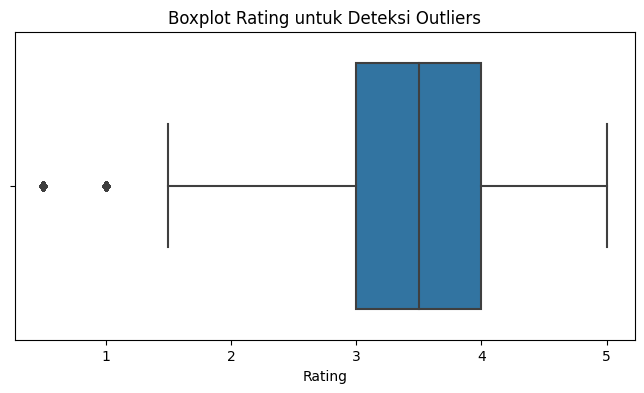

In [13]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=ratings_df['rating'])
plt.title("Boxplot Rating untuk Deteksi Outliers")
plt.xlabel("Rating")
plt.show()

**Insight**

1. Pemeriksaan Isi Awal Dataset
  - Lima baris pertama movies_df menunjukkan variasi genre yang kompleks, berguna untuk sistem berbasis konten.
  - Lima baris pertama ratings_df menunjukkan bahwa satu user dapat memberi rating ke banyak film, cocok untuk collaborative filtering.

2. Pemeriksaan Duplikasi
  - Tidak ditemukan baris duplikat di movies_df maupun ratings_df.
  - Ini memastikan tidak ada pengaruh bias dari data ganda saat training model.

3. Pemeriksaan Missing Values
  - Semua kolom di kedua dataset tidak mengandung missing values.
  
    Artinya, dataset bersih dan siap digunakan tanpa proses imputasi atau pembersihan lanjutan.

4. 0.5 dan 1.0 terdeteksi sebagai outlier statistik, namun dipertahankan karena masuk dalam domain rating yang sah. Karena:
  - Nilai tersebut termasuk dalam skala rating yang valid.
  - Dalam Collaborative Filtering, setiap rating (rendah sekalipun) berkontribusi dalam mempelajari preferensi user.


## Distribusi Data

Tahap ini bertujuan memahami pola sebaran nilai pada satu variabel dalam dataset,

### UNIVARIATE ANALYSIS

In [14]:
rating_stats = ratings_df['rating'].describe()
rating_counts = ratings_df['rating'].value_counts().sort_index()
print(rating_stats)
print(rating_counts)

count    2.500010e+07
mean     3.533854e+00
std      1.060744e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64
rating
0.5     393068
1.0     776815
1.5     399490
2.0    1640868
2.5    1262797
3.0    4896928
3.5    3177318
4.0    6639798
4.5    2200539
5.0    3612474
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


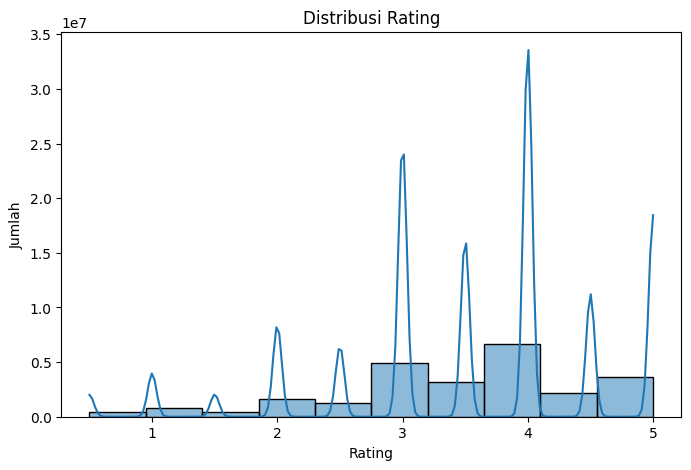

In [15]:
# Distribusi rating
plt.figure(figsize=(8,5))
sns.histplot(ratings_df['rating'], bins=10, kde=True)
plt.title("Distribusi Rating")
plt.xlabel("Rating")
plt.ylabel("Jumlah")
plt.show()

In [16]:
# Jumlah rating per film
ratings_per_movie = ratings_df.groupby('movieId')['rating'].count().reset_index()
ratings_per_movie.columns = ['movieId', 'jumlah_rating']

# Top 10 film dengan jumlah rating terbanyak
top_movies = ratings_per_movie.sort_values(by='jumlah_rating', ascending=False).head(10)
print("Top 10 Film dengan Jumlah Rating Terbanyak:")
print(top_movies.to_string(index=False))
print("\n")

Top 10 Film dengan Jumlah Rating Terbanyak:
 movieId  jumlah_rating
     356          81491
     318          81482
     296          79672
     593          74127
    2571          72674
     260          68717
     480          64144
     527          60411
     110          59184
    2959          58773




In [17]:
# Statistik rating rata-rata tiap film
rating_count = ratings_df.groupby('movieId').size().reset_index(name='rating_count')
movie_stats = ratings_df.groupby('movieId')['rating'].agg(['mean', 'count']).rename(columns={'mean': 'average_rating', 'count': 'num_ratings'})
movie_stats = movie_stats.merge(movies_df, on='movieId')
top_rated = movie_stats.sort_values(by='num_ratings', ascending=False).head(10)

print("Top 10 film dengan rating terbanyak:")
print(top_rated[['title', 'average_rating', 'num_ratings']])

Top 10 film dengan rating terbanyak:
                                          title  average_rating  num_ratings
351                         Forrest Gump (1994)        4.048011        81491
314            Shawshank Redemption, The (1994)        4.413576        81482
292                         Pulp Fiction (1994)        4.188912        79672
585            Silence of the Lambs, The (1991)        4.151342        74127
2480                         Matrix, The (1999)        4.154099        72674
257   Star Wars: Episode IV - A New Hope (1977)        4.120189        68717
475                        Jurassic Park (1993)        3.679175        64144
522                     Schindler's List (1993)        4.247579        60411
108                           Braveheart (1995)        4.002273        59184
2867                          Fight Club (1999)        4.228311        58773


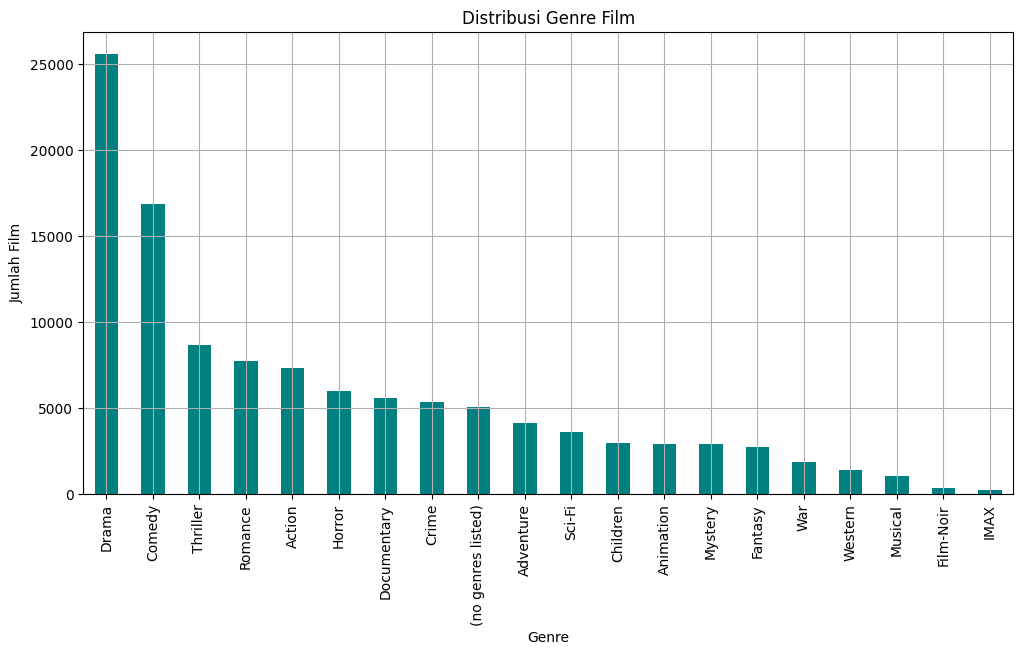

In [18]:
# Distribusi Genre Film

genres = movies_df['genres'].str.split('|').explode()

plt.figure(figsize=(12,6))
genres.value_counts().plot(kind='bar', color='teal')
plt.title('Distribusi Genre Film')
plt.xlabel('Genre')
plt.ylabel('Jumlah Film')
plt.grid(True)
plt.show()

**Insight**


#### 1. Distribusi Rating Film
- Rating berkisar antara **0.5 hingga 5.0**, dengan interval 0.5.
- **Mean** (rata-rata): 3.53 → menunjukkan mayoritas pengguna memberikan rating positif.
- **Median** (nilai tengah): 3.5 → setengah data di bawah/di atas nilai ini.
- **Modus** (rating terbanyak): 4.0.
- Distribusi cenderung **normal**, namun sedikit **skew ke kiri**.
- Visualisasi histogram menunjukkan kepadatan tertinggi pada rating 3.0 hingga 4.0.

#### 2. Jumlah Rating per Film
- Terdapat film-film yang memiliki rating jauh lebih banyak dibandingkan lainnya.
- **Top 3 film dengan rating terbanyak**:
  - Forrest Gump (1994) – 81.491 rating
  - The Shawshank Redemption (1994) – 81.482 rating
  - Pulp Fiction (1994) – 79.672 rating
- Menunjukkan adanya **ketimpangan interaksi pengguna** terhadap film.

#### 3. Statistik Rating Rata-Rata Tiap Film
- Rata-rata rating dihitung per `movieId` dan digabung dengan data judul.
- Film seperti *The Shawshank Redemption* memiliki **average rating tinggi** (4.41) dan jumlah rating besar.
- Berguna untuk sistem rekomendasi: mempertimbangkan film populer dan berkualitas.

#### 4. Distribusi Genre Film
- Genre diekstrak dan dihitung frekuensinya.
- Genre terbanyak:
  - Drama
  - Comedy
  - Action
- Visualisasi bar chart menunjukkan dominasi genre tertentu.
- Dapat dimanfaatkan dalam model **Content-Based Filtering** berbasis genre preferensi pengguna.


### MULTIVARIATE ANALYSIS

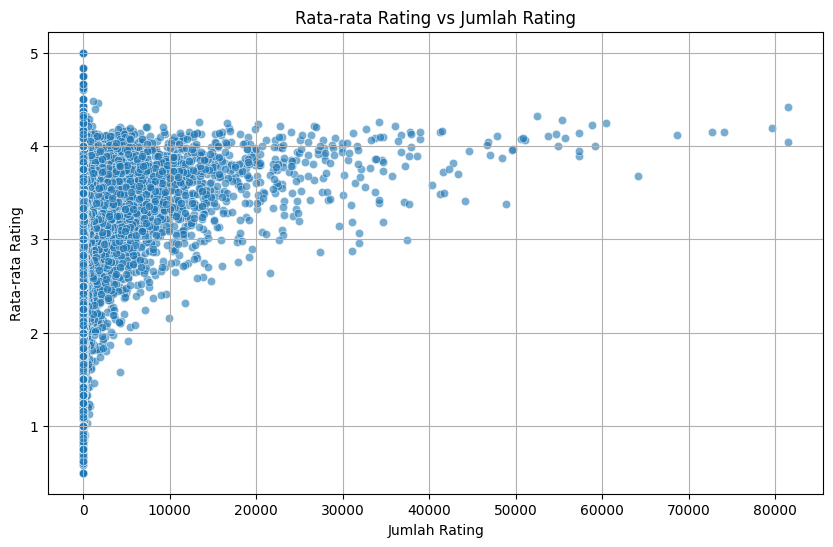

In [19]:
# Korelasi jumlah dan rata-rata rating per film

movie_stats = ratings_df.groupby('movieId').agg(
    mean_rating=('rating', 'mean'),
    rating_count=('rating', 'count')
).reset_index()

plt.figure(figsize=(10,6))
sns.scatterplot(data=movie_stats, x='rating_count', y='mean_rating', alpha=0.6)
plt.title('Rata-rata Rating vs Jumlah Rating')
plt.xlabel('Jumlah Rating')
plt.ylabel('Rata-rata Rating')
plt.grid(True)
plt.show()

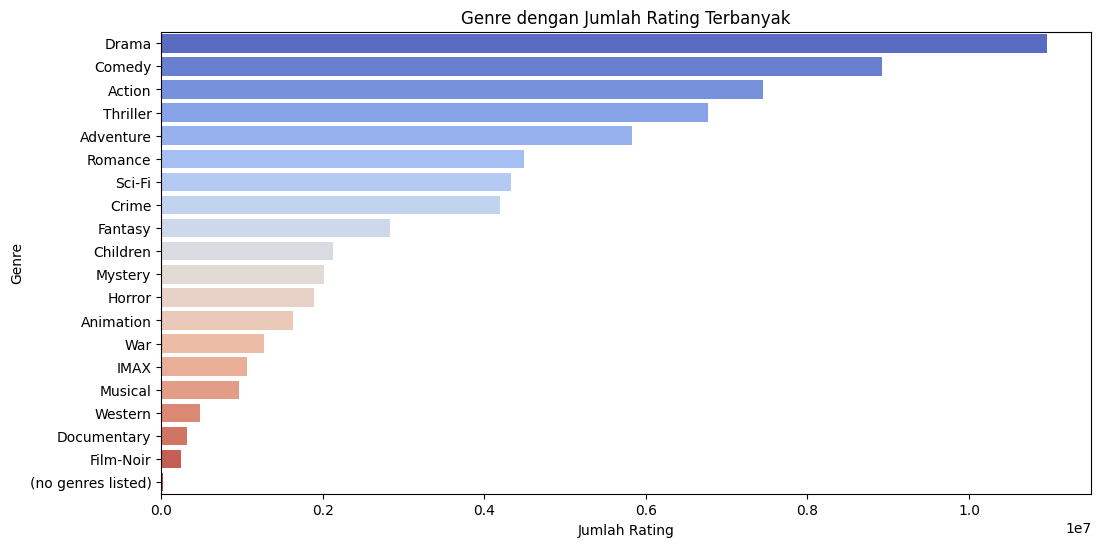

In [20]:
rating_count = ratings_df.groupby('movieId').size().reset_index(name='rating_count')
movies_with_count = pd.merge(movies_df, rating_count, on='movieId', how='left')
movies_with_count['genres'] = movies_with_count['genres'].str.split('|')
genre_exploded = movies_with_count.explode('genres')
genre_popularity = genre_exploded.groupby('genres')['rating_count'].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=genre_popularity.values, y=genre_popularity.index, palette='coolwarm')
plt.title('Genre dengan Jumlah Rating Terbanyak')
plt.xlabel('Jumlah Rating')
plt.ylabel('Genre')
plt.show()

**Insight**

## Analisis Plot: Rata-rata Rating vs Jumlah Rating
1. Distribusi Data
  - Sebagian besar film memiliki jumlah rating yang sangat rendah (mendekati 0–500).
  - Ada beberapa film populer dengan jumlah rating yang sangat tinggi (hingga puluhan ribu).
  - Rata-rata rating berkisar antara 2 hingga 5.

2. Pola dan Persebaran

  - Banyak film dengan jumlah rating rendah (kurang dari 1000) memiliki variabilitas rating yang sangat besar. Artinya, ada film dengan jumlah rating sedikit tapi ratingnya bisa sangat rendah (1) atau sangat tinggi (5).
  - Film dengan jumlah rating yang besar (ribuan hingga puluhan ribu) cenderung memiliki rata-rata rating yang lebih stabil (biasanya di rentang 3.5 – 4.5). Ini karena semakin banyak orang memberi rating, biasanya nilai rata-rata akan mendekati nilai populasi sebenarnya (hukum angka besar).
  - Tidak ada korelasi linier yang kuat antara jumlah rating dan rata-rata rating. Artinya, film populer (dengan banyak rating) tidak selalu memiliki rata-rata rating yang lebih tinggi atau lebih rendah.

3. Outlier
  - Ada beberapa film dengan jumlah rating yang sangat tinggi (misalnya, di atas 50,000–80,000). Film-film ini kemungkinan adalah film blockbuster atau film klasik populer yang ditonton dan dirating oleh banyak orang.
  - Beberapa film dengan rating yang sangat rendah (sekitar 1-2) bahkan ada yang memiliki jumlah rating yang cukup banyak (di atas 10,000). Ini menunjukkan ada film yang terkenal namun tidak disukai.


#### Interpretasi Statistik
- Rata-rata rating film populer cenderung mendekati angka 4, dengan variasi yang lebih kecil dibanding film dengan jumlah rating rendah.
- Semakin sedikit jumlah rating, semakin besar ketidakpastian pada rata-rata rating. Artinya, rating rata-rata film dengan jumlah rating rendah kurang bisa dipercaya sebagai representasi kualitas film yang sebenarnya.


## Analisis Visualisasi: Genre dengan Jumlah Rating Terbanyak

1. Genre Paling Populer
  - Drama dan Comedy adalah genre andalan — hampir pasti muncul dalam daftar rekomendasi untuk pengguna baru.
  - Genre seperti Film-Noir, Documentary, dan Western memiliki jumlah rating yang jauh lebih rendah, artinya lebih niche atau spesifik ke audiens tertentu.

2. Pola yang Muncul
  - Genre populer umumnya adalah genre yang sering diproduksi oleh industri film, dengan jangkauan penonton luas.
  - Genre dengan jumlah rating rendah cenderung merupakan genre khusus atau spesialisasi, yang mungkin kurang menarik bagi mayoritas penonton.

3. Pertimbangan dalam Rekomendasi
  - Sistem rekomendasi cenderung akan terbias terhadap genre populer (Drama, Comedy, dll.), sehingga perlu perhatian khusus untuk:
  - Menjaga diversitas genre dalam rekomendasi.
  - Meningkatkan eksposur ke genre kurang populer namun relevan dengan preferensi pengguna.



# Data Preprocessing

## Menggabungkan ratings_df dan movies_df berdasarkan movieId

Penggabungan (merge) antara ratings_df dan movies_df berdasarkan kolom movieId sangat penting dalam proyek sistem rekomendasi, karena memberikan konteks konten pada data interaksi pengguna

In [21]:
merged_df = pd.merge(ratings_df, movies_df, on='movieId', how='left')
merged_df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
2,1,307,5.0,1147868828,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,1,665,5.0,1147878820,Underground (1995),Comedy|Drama|War
4,1,899,3.5,1147868510,Singin' in the Rain (1952),Comedy|Musical|Romance


In [22]:
missing_percentage = merged_df.isnull().mean() * 100
print("Missing value percentage per column:\n", missing_percentage)

Missing value percentage per column:
 userId       0.0
movieId      0.0
rating       0.0
timestamp    0.0
title        0.0
genres       0.0
dtype: float64


Checking Duplicate Value

In [23]:
# Cek duplikat baris di merged_df
merged_duplicates = merged_df.duplicated().sum()
print(f"Jumlah duplikat baris di merged_df: {merged_duplicates}")

Jumlah duplikat baris di merged_df: 0


In [24]:
# Cek duplikat userId dan movieId
duplicate_ratings = merged_df.duplicated(subset=['userId', 'movieId']).sum()
print(f"Jumlah duplikat berdasarkan userId dan movieId: {duplicate_ratings}")

Jumlah duplikat berdasarkan userId dan movieId: 0


# Data Preparation

## Ambil 200.000 sample data (karena RAM terbatas)

In [25]:
sample_df = merged_df.sample(n=200_000, random_state=42).copy()

In [26]:
# Transformasi Fitur Genre
sample_df['genres'] = sample_df['genres'].str.split('|')

# Explode agar tiap genre jadi baris tersendiri
genre_exploded = sample_df.explode('genres')

Visualisasi Heatmap (Tidak bisa di section MultiVariate Karena Jumlah data yang besar jadi harus menggunakan data yang lebih sedikit (baru dilakukan di section ini) )

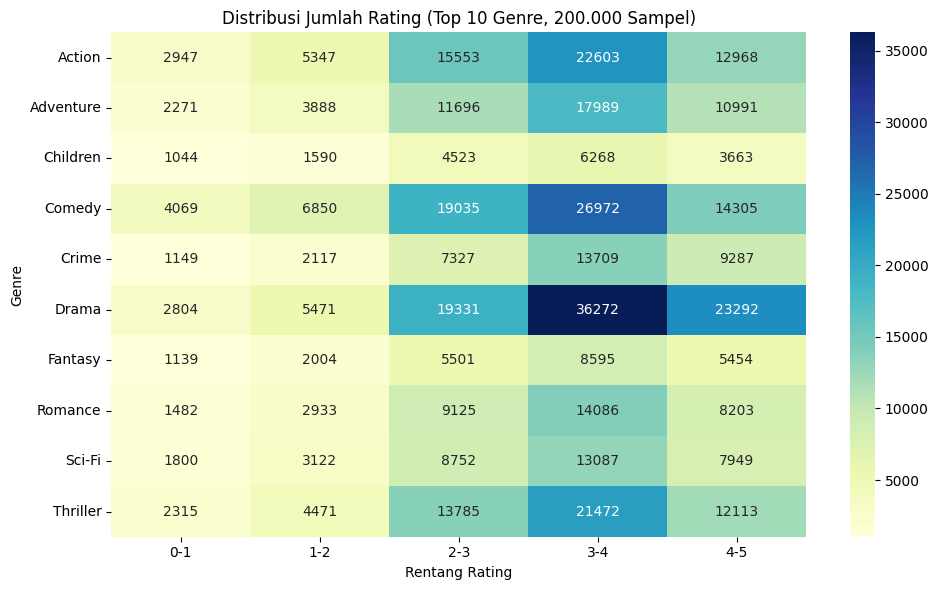

In [27]:
# Kategori rating 
genre_exploded['rating_category'] = pd.cut(
    genre_exploded['rating'],
    bins=[0, 1, 2, 3, 4, 5],
    labels=['0-1', '1-2', '2-3', '3-4', '4-5'],
    include_lowest=True,
    right=True  # agar intervalnya (a,b], default sudah True
)

# Top 10 genre terbanyak
top_genres = genre_exploded['genres'].value_counts().head(10).index
filtered_genre = genre_exploded[genre_exploded['genres'].isin(top_genres)]

rating_pivot = filtered_genre.pivot_table(
    index='genres',
    columns='rating_category',
    values='rating',
    aggfunc='count',
    fill_value=0,
    observed=True
)

if rating_pivot.empty:
    print("Pivot table kosong, cek data input dan filtering genre/ rating_category.")
else:
    # Visualisasi heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(rating_pivot, cmap='YlGnBu', annot=True, fmt='d')
    plt.title('Distribusi Jumlah Rating (Top 10 Genre, 200.000 Sampel)')
    plt.xlabel('Rentang Rating')
    plt.ylabel('Genre')
    plt.tight_layout()
    plt.show()

## **Insight Preprossing dan Heatmap**

- Data sudah bersih tidak ada nilai missing value dan duplikasi sehingga tidak perlu dilakukan preprosesing.
- Sampling dilakukan untuk menghindari keterbatasan memori tanpa mengorbankan distribusi data.
- Genre film dipisahkan menjadi list (split('|')) dan dipecah menjadi baris terpisah (explode).
- Hasil visualisasi heatmap menunjukkan:
  - Genre seperti Drama dan Comedy mendominasi jumlah rating.
  - Sebagian besar genre memiliki rating di rentang 3-4 dan 4-5.
- Genre akan menjadi fitur utama dalam sistem rekomendasi berbasis konten.

## Data Preparation Model Content Based

In [28]:
# kolom yang dibutuhkan
movie_content = movies_df[['movieId', 'title', 'genres']].copy()

# Ganti genre "(no genres listed)" menjadi string kosong
movie_content['genres'] = movie_content['genres'].replace("(no genres listed)", "")

In [29]:
# Filter movie yang ada di sample
sample_movie_ids = sample_df['movieId'].unique()
filtered_movies = movie_content[movie_content['movieId'].isin(sample_movie_ids)].reset_index(drop=True)

# genre dan title jadi satu fitur teks
filtered_movies['text_features'] = filtered_movies['genres'] + " " + filtered_movies['title']

### TF-IDF Vectorizer

Untuk mengubah fitur teks (genre + judul film) menjadi representasi numerik.

In [30]:
tfidf = TfidfVectorizer(token_pattern=r'[^| ]+', stop_words='english')
tfidf_matrix = tfidf.fit_transform(filtered_movies['text_features'])
print("Ukuran TF-IDF Matrix:", tfidf_matrix.shape)

Ukuran TF-IDF Matrix: (13198, 14494)


## Data Preparation Model Collaborative Filtering

### Label Encoding

In [31]:
user_ids = sample_df['userId'].unique().tolist()
movie_ids = sample_df['movieId'].unique().tolist()

user_to_encoded = {x: i for i, x in enumerate(user_ids)}
movie_to_encoded = {x: i for i, x in enumerate(movie_ids)}
encoded_to_movie = {i: x for x, i in movie_to_encoded.items()}
encoded_to_user = {i: x for x, i in user_to_encoded.items()}

sample_df['user'] = sample_df['userId'].map(user_to_encoded)
sample_df['movie'] = sample_df['movieId'].map(movie_to_encoded)

### Normalisasi

In [32]:
# Normalisasi rating
min_rating = sample_df['rating'].min()
max_rating = sample_df['rating'].max()
sample_df['norm_rating'] = sample_df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating))

### Membagi data untuk training dan validasi

In [33]:
from sklearn.model_selection import train_test_split
x = sample_df[['user', 'movie']].values
y = sample_df['norm_rating'].values
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

80% data latih (training set) digunakan untuk: Melatih model dan menyesuaikan bobot (belajar dari data).

20% data validasi (validation set) digunakan untuk:
- Mengevaluasi performa model selama pelatihan tanpa ikut melatih.
- Memantau overfitting (ketika model terlalu menghafal data latih dan tidak generalisasi dengan baik).

Note :

Pembagian 80:20 dengan mempertimbangkan jumlah sampel data yang digunakan yatu 200.000 data yang mana termasuk dalam skala data Sedang (100.000 - 1 juta rating) sehingga cukup baik dengan menggunakan perbandingan ini.

# Model Development Content Based Filtering

Membangun representasi fitur konten (genre) untuk film-film, yang menjadi dasar dari content-based filtering. Ini memungkinkan untuk merekomendasikan film yang genre-nya mirip dengan film yang disukai pengguna.

## Cosine Similarity

Cosine similarity mengukur kemiripan antar dua vektor berdasarkan vektor TF-IDF. Nilai similarity berkisar antara 0 (tidak mirip) hingga 1 (sangat mirip/identik).

In [34]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim_df = pd.DataFrame(
    cosine_sim,
    index=filtered_movies['title'],
    columns=filtered_movies['title']
)

In [35]:
print("Contoh Cosine Similarity Matrix:")
display(cosine_sim_df.sample(5, random_state=42).sample(5, axis=1, random_state=42))

Contoh Cosine Similarity Matrix:


title,Troy (2004),Unstoppable (2010),"Battle of Shaker Heights, The (2003)",Madras (2014),J. Edgar (2011)
title,,,,,
Troy (2004),1.000000,0.079207,0.014680,0.081538,0.017179
Unstoppable (2010),0.079207,1.000000,0.016251,0.090261,0.019017
"Battle of Shaker Heights, The (2003)",0.014680,0.016251,1.000000,0.016729,0.012717
Madras (2014),0.081538,0.090261,0.016729,1.000000,0.019577
J. Edgar (2011),0.017179,0.019017,0.012717,0.019577,1.000000


**Insight**

- Film cenderung memiliki kemiripan tinggi dengan film yang genre-nya serupa.
- Mayoritas nilai kemiripan antar film rendah (0), menunjukkan bahwa sebagian besar film memiliki genre, tema, atau fitur yang sangat berbeda.
- Matrix ini menjadi dasar Content-Based Filtering:
Misalnya, jika user suka Madras (2014)	, sistem akan menyarankan film dengan nilai similarity tertinggi, seperti Unstoppable (2010).

## Evaluasi Score

In [36]:
# Fungsi Rekomendasi dengan Penalti Popularitas

def get_top_n_recommendations_penalty(user_movie_titles, similarity_matrix, n=10, global_counter=None, alpha=0.6):
    scores = similarity_matrix.loc[user_movie_titles].mean(axis=0)
    scores = scores.drop(user_movie_titles, errors='ignore')
    
    if global_counter is not None:
        penalty = scores.index.to_series().apply(lambda x: global_counter[x])
        penalty = penalty / (penalty.max() + 1e-6)  # Normalisasi
        scores = scores - alpha * penalty
    return scores.sort_values(ascending=False).head(n).index.tolist()

# Evaluasi

ils_list = []
all_recommended = set()
recommend_count = defaultdict(int)

user_ids = sample_df['userId'].unique()[:1000]  # hanya 1000 user

for user in user_ids:
    user_data = sample_df[sample_df['userId'] == user]
    user_movie_titles = user_data['title'].tolist()
    user_movie_titles = [title for title in user_movie_titles if title in cosine_sim_df.index]
    
    if len(user_movie_titles) < 1:
        continue

    recommended_titles = get_top_n_recommendations_penalty(
        user_movie_titles, cosine_sim_df, n=10, global_counter=recommend_count, alpha=0.6
    )

    for title in recommended_titles:
        recommend_count[title] += 1
    all_recommended.update(recommended_titles)

    if len(recommended_titles) > 1:
        sim_scores = cosine_sim_df.loc[recommended_titles, recommended_titles].values
        upper_triangle_indices = np.triu_indices_from(sim_scores, k=1)
        ils = np.mean(sim_scores[upper_triangle_indices])
        ils_list.append(ils)

mean_ils = np.mean(ils_list)
diversity_score = 1 - mean_ils
coverage = len(all_recommended) / len(cosine_sim_df)

print("\nEvaluation - Content-Based Filtering with Coverage Boost:")
print(f"Mean Similarity (ILS) : {mean_ils:.4f}")
print(f"Diversity Score       : {diversity_score:.4f}")
print(f"Coverage              : {coverage:.4f}")


Evaluation - Content-Based Filtering with Coverage Boost:
Mean Similarity (ILS) : 0.1261
Diversity Score       : 0.8739
Coverage              : 0.7428


**Insight**
1. Mean Similarity (ILS) = 0.1261
Nilai Intra-List Similarity yang relatif rendah menunjukkan bahwa daftar rekomendasi memiliki tingkat keberagaman konten yang cukup baik. Artinya, item-item yang direkomendasikan kepada pengguna tidak terlalu mirip satu sama lain secara konten (genre/deskripsi), sehingga pengguna mendapatkan rekomendasi yang lebih variatif.

2. Diversity Score = 0.8739
Skor diversity yang tinggi memperkuat temuan dari ILS, mengindikasikan bahwa model berhasil merekomendasikan film dari berbagai kategori atau kelompok berbeda. Ini penting untuk menjaga pengalaman pengguna tetap segar dan menghindari rekomendasi yang monoton.

3. Coverage = 0.7428
Nilai coverage yang tinggi (74.28%) menunjukkan bahwa model berhasil mengeksplorasi dan merekomendasikan sebagian besar item yang tersedia di katalog. Ini adalah hasil langsung dari penerapan teknik coverage boosting, yang mendorong model untuk merekomendasikan lebih banyak item yang kurang populer atau jarang dipilih sebelumnya.

## Mendapatkan Rekomendasi CBF (Output)

In [37]:
def recommend_from_filtered_movies_with_similarity(sample_df, filtered_movies, cosine_sim, k=10, alpha=0.6, lam=0.5):

    movie_title = random.choice(sample_df['title'].unique())
    idx = filtered_movies.index[filtered_movies['title'] == movie_title][0]
    movie_genres = filtered_movies.loc[idx, 'genres']

    print(f"\nFilm Utama: {movie_title}")
    print(f"   Genre    : {movie_genres}")

    # Skor penalti popularitas
    pop = sample_df['movieId'].value_counts()
    pop_norm = filtered_movies['movieId'].map(lambda x: pop.get(x, 0))
    pop_norm = (pop_norm - pop_norm.min()) / (pop_norm.max() - pop_norm.min() + 1e-6)

    # Skor similarity - penalti popularitas
    scores = cosine_sim[idx] - alpha * pop_norm.values

    candidates = filtered_movies.index[filtered_movies.index != idx]
    candidate_scores = scores[candidates]
    candidate_ids = filtered_movies.loc[candidates, 'movieId'].tolist()

    selected, genres_sel = [], []
    movie_ids, scores_arr = candidate_ids.copy(), candidate_scores.copy()

    # Reranking dengan penalti kemiripan genre
    for _ in range(min(k, len(movie_ids))):
        penalties = []
        for m in movie_ids:
            genre_m = set(filtered_movies.loc[filtered_movies['movieId'] == m, 'genres'].values[0].split('|'))
            penalty = sum(len(genre_m.intersection(g)) for g in genres_sel)
            penalties.append(penalty)
        combined = scores_arr - lam * np.array(penalties)
        i = np.argmax(combined)
        selected.append(movie_ids.pop(i))
        genres_sel.append(set(filtered_movies.loc[filtered_movies['movieId'] == selected[-1], 'genres'].values[0].split('|')))
        scores_arr = np.delete(scores_arr, i)

    # Hasil rekomendasi
    print("\nRekomendasi Film:")
    for mid in selected:
        row = filtered_movies[filtered_movies['movieId'] == mid].iloc[0]
        idx_rec = filtered_movies.index[filtered_movies['movieId'] == mid][0]
        sim = cosine_sim[idx, idx_rec]
        print(f"- {row['title']} ({row['genres']})")
        print(f"  ↳ Similarity ke film utama : {sim:.4f}")
        print(f"  ↳ Diversity Score          : {1 - sim:.4f}")

    # Statistik rating
    stats = sample_df[sample_df['movieId'].isin(selected)].groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()
    stats = stats.merge(filtered_movies[['movieId', 'title']], on='movieId', how='left')
    stats = stats.rename(columns={'mean':'avg_rating', 'count':'num_ratings'})

    print("\nStatistik Rating Film Rekomendasi:")
    display(stats.sort_values(by='avg_rating', ascending=False).reset_index(drop=True))

    return [filtered_movies[filtered_movies['movieId'] == mid]['title'].values[0] for mid in selected]

In [38]:
recommended = recommend_from_filtered_movies_with_similarity(
    sample_df=sample_df,
    filtered_movies=filtered_movies,
    cosine_sim=cosine_sim,
    k=10,
    alpha=0.6,
    lam=0.5
)


Film Utama: Videodrome (1983)
   Genre    : Fantasy|Horror|Sci-Fi|Thriller

Rekomendasi Film:
- Under Fire (1983) (Drama|Thriller|War)
  ↳ Similarity ke film utama : 0.3985
  ↳ Diversity Score          : 0.6015
- Krull (1983) (Action|Adventure|Fantasy|Sci-Fi)
  ↳ Similarity ke film utama : 0.3444
  ↳ Diversity Score          : 0.6556
- The Hunger (1983) (Horror)
  ↳ Similarity ke film utama : 0.3175
  ↳ Diversity Score          : 0.6825
- Class (1983) (Comedy)
  ↳ Similarity ke film utama : 0.2476
  ↳ Diversity Score          : 0.7524
- Mickey's Christmas Carol (1983) (Animation|Children)
  ↳ Similarity ke film utama : 0.1541
  ↳ Diversity Score          : 0.8459
- Sunless (Sans Soleil) (1983) (Documentary)
  ↳ Similarity ke film utama : 0.1443
  ↳ Diversity Score          : 0.8557
- Inspector General, The (1949) (Musical)
  ↳ Similarity ke film utama : 0.0000
  ↳ Diversity Score          : 1.0000
- Madagascar Skin (1995) (Romance)
  ↳ Similarity ke film utama : 0.0000
  ↳ Diversity S

,movieId,avg_rating,num_ratings,title
0,963,4.00,1,"Inspector General, The (1949)"
1,1154,4.00,1,T-Men (1947)
2,136542,4.00,1,Mickey's Christmas Carol (1983)
3,6123,3.75,2,Sunless (Sans Soleil) (1983)
4,7480,3.50,1,Under Fire (1983)
5,4275,3.50,6,Krull (1983)
6,3550,3.25,8,The Hunger (1983)
7,983,3.00,1,Madagascar Skin (1995)
8,2241,2.50,3,Class (1983)
9,1386,1.00,1,Terror in a Texas Town (1958)


# Model Development dengan Collaborative Filtering

Struktur Model yang dibangun menggunakan **Model RecommenderNet**

Model Collaborative Filtering  menggunakan pendekatan berbasis pembelajaran mendalam (Deep Learning), tepatnya melalui teknik Matrix Factorization dengan Embedding Layer pada framework TensorFlow. Tujuan utamanya adalah mempelajari hubungan implisit antara interaksi pengguna dengan item (film), untuk memprediksi rating atau preferensi pengguna terhadap film yang belum ditonton.

Komponen Utama:
1. User Embedding & Movie Embedding:

   Mewakili pengguna dan film dalam ruang vektor berdimensi 150. Ini memungkinkan model memahami relasi pengguna dan film berdasarkan data interaksi (misalnya rating).

2. User Bias & Movie Bias:

   Menambahkan bias individual untuk pengguna dan film, membantu model menangkap preferensi umum yang tidak ditangkap oleh embedding.

3. Dot Product:

   Mengalikan elemen-elemen vektor embedding pengguna dan film sebagai prediksi rating dasar.

4.  Aktivasi Sigmoid:

   Model memprediksi dengan label yang dinormalisasi ke [0,1].

## Modeling

In [39]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_size=150, dropout_rate=0.2, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)

        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(input_dim=num_users, output_dim=1)

        self.movie_embedding = layers.Embedding(
            input_dim=num_movies,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(input_dim=num_movies, output_dim=1)

        self.dropout = layers.Dropout(dropout_rate)

    def call(self, inputs):
        user_vector = self.dropout(self.user_embedding(inputs[:, 0]))
        movie_vector = self.dropout(self.movie_embedding(inputs[:, 1]))

        user_bias = self.user_bias(inputs[:, 0])
        movie_bias = self.movie_bias(inputs[:, 1])

        dot_product = tf.reduce_sum(user_vector * movie_vector, axis=1, keepdims=True)
        x = dot_product + user_bias + movie_bias

        return tf.nn.sigmoid(x)  # gunakan sigmoid jika label dinormalisasi ke [0,1]

In [40]:
# INISIALISASI
num_users = len(user_to_encoded)
num_movies = len(movie_to_encoded)

# data input berupa np.array
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

model = RecommenderNet(num_users, num_movies, embedding_size=150, dropout_rate=0.2)
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

I0000 00:00:1748566950.083828      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## Proses Training

In [41]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [42]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/50


I0000 00:00:1748566953.321307     103 service.cc:148] XLA service 0x7bd4a4003dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748566953.321802     103 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748566953.564180     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


  45/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6939 - root_mean_squared_error: 0.2928  

I0000 00:00:1748566954.087217     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.6883 - root_mean_squared_error: 0.2889 - val_loss: 0.6727 - val_root_mean_squared_error: 0.2752
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6631 - root_mean_squared_error: 0.2660 - val_loss: 0.6585 - val_root_mean_squared_error: 0.2597
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6273 - root_mean_squared_error: 0.2277 - val_loss: 0.6524 - val_root_mean_squared_error: 0.2480
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5908 - root_mean_squared_error: 0.1806 - val_loss: 0.6523 - val_root_mean_squared_error: 0.2412
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5683 - root_mean_squared_error: 0.1452 - val_loss: 0.6537 - val_root_mean_squared_error: 0.2367
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5564 - root_mean_squared_error: 0.1221 - val_loss: 0.6549 - val_root_mean_squared_error: 0.2337
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/s

## Evaluasi Metrik

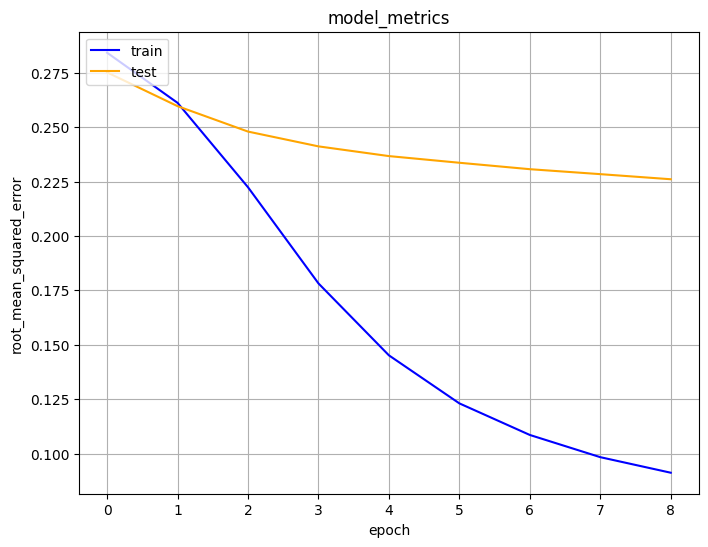

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['root_mean_squared_error'], label='train', color='blue')
plt.plot(history.history['val_root_mean_squared_error'], label='test', color='orange')
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

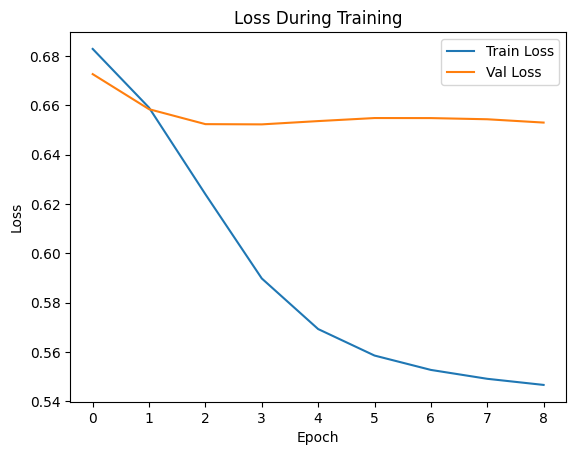

In [44]:
# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss During Training')
plt.show()

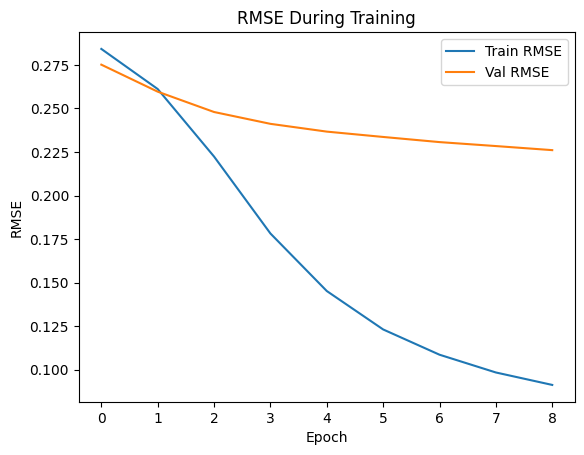

In [45]:
# Plot RMSE
plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE During Training')
plt.show()

**Insight**

1. Grafik menunjukkan penurunan RMSE yang stabil pada data training dan validation.
2. Train RMSE menurun signifikan dari awal hingga epoch 8, menunjukkan model belajar dengan baik dari data.
3. Val RMSE juga menurun, meskipun lebih lambat, tanpa indikasi overfitting (tidak ada kenaikan drastis pada Val RMSE).
4. Gap Train-Val RMSE relatif kecil, menunjukkan model cukup stabil dan generalizable untuk data baru.
5. Secara keseluruhan, model Collaborative Filtering ini menunjukkan performa yang baik dan tidak overfit terhadap data training.

## Evaluasi Score

In [46]:
def calculate_metrics_better_coverage(model, sample_df, user_to_encoded, movie_to_encoded, encoded_to_movie,
                                      top_k=10, sample_data=1000, alpha=0.6, temperature=1.5):
    sample_subset = sample_df.sample(n=sample_data, random_state=42)
    user_ids = sample_subset['userId'].unique()

    recommended_items = set()
    diversity_scores = []
    similarity_scores = []

    movie_embeddings = model.movie_embedding(np.arange(len(movie_to_encoded))).numpy()

    movie_popularity = sample_df['movieId'].value_counts()
    movie_popularity = movie_popularity / movie_popularity.max()

    popularity_penalty = {movie_id: movie_popularity.get(movie_id, 0.0) for movie_id in movie_to_encoded.keys()}

    def sample_top_k(preds, k=10, temperature=1.0):
        preds = preds - np.max(preds)
        exp_preds = np.exp(preds / temperature)
        probs = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), size=k, replace=False, p=probs)

    for user_id in user_ids:
        if user_id not in user_to_encoded:
            continue
        encoded_user = user_to_encoded[user_id]

        user_vector = tf.constant([[encoded_user] * len(movie_to_encoded), list(range(len(movie_to_encoded)))]).numpy().T
        predictions = model.predict(user_vector, verbose=0).flatten()

        penalty_array = np.array([
            popularity_penalty.get(encoded_to_movie[i], 0.0) for i in range(len(movie_to_encoded))
        ])
        adjusted_preds = predictions - alpha * penalty_array

        # Sampling top-k
        top_indices = sample_top_k(adjusted_preds, k=top_k, temperature=temperature)
        recommended_items.update(top_indices)

        rec_embeds = movie_embeddings[top_indices]
        normed = rec_embeds / np.linalg.norm(rec_embeds, axis=1, keepdims=True)
        sim_matrix = np.dot(normed, normed.T)
        upper_tri = sim_matrix[np.triu_indices(top_k, k=1)]
        mean_sim = np.mean(upper_tri)

        similarity_scores.append(mean_sim)
        diversity_scores.append(1 - mean_sim)

    mean_similarity = np.mean(similarity_scores)
    mean_diversity = np.mean(diversity_scores)
    coverage = len(recommended_items) / len(movie_to_encoded)

    return mean_similarity, mean_diversity, coverage

mean_sim, mean_div, coverage = calculate_metrics_better_coverage(
    model,
    sample_df,
    user_to_encoded,
    movie_to_encoded,
    encoded_to_movie,
    sample_data=1000,
    top_k=10,
    alpha=0.6,
    temperature=1.5
)

print("\nEvaluation - Collaborative Filtering with Coverage Boost:")
print(f"Mean Similarity (ILS)     : {mean_sim:.4f}")
print(f"Diversity Score           : {mean_div:.4f}")
print(f"Coverage                  : {coverage:.4f}")


Evaluation - Collaborative Filtering with Coverage Boost:
Mean Similarity (ILS)     : 0.0232
Diversity Score           : 0.9768
Coverage                  : 0.5281


**insight**

- Mean Similarity (ILS): 0.0232
  Model berhasil menyarankan film dengan tema, genre, atau atribut berbeda untuk satu pengguna, menciptakan daftar yang variatif.

- Diversity Score: 0.9768
  Pengguna mendapat eksplorasi konten yang luas dari berbagai genre dan gaya film, yang dapat meningkatkan pengalaman dan penemuan (discovery).

- Coverage: 0.5281
  Model tidak hanya merekomendasikan film populer yang sering muncul, tapi juga menyebar rekomendasi ke film-film dengan interaksi rendah (long-tail items).

In [47]:
# # Contoh penerapan mean_sim yang menggambarkan rata-rata kemiripan antar item dalam daftar rekomendasi

# mean_sims = [1.0, 0.8, 0.5, 0.2, 0.0]  # dari sangat mirip hingga tidak mirip

# print("Mean Similarity (mean_sim)  |  Diversity Score (1 - mean_sim)")
# print("-" * 50)

# for mean_sim in mean_sims:
#     diversity_score = 1 - mean_sim
#     print(f"{mean_sim:>25.2f}  |  {diversity_score:>23.2f}")

Code ini dapat dijadikan panduan mengenai pemahaman ILS dengan Diversity pada project ini

## Mendapatkan Rekomendasi CF (Output)

In [48]:
user_id = sample_df['userId'].sample(1).iloc[0]

# List film yang sudah ditonton
watched = sample_df[sample_df['userId'] == user_id]['movieId'].tolist()

# Film yang belum ditonton
not_watched = movies_df[~movies_df['movieId'].isin(watched)]
not_watched = not_watched[not_watched['movieId'].isin(movie_to_encoded.keys())]
not_watched_ids = not_watched['movieId'].tolist()

# Encode user dan movie
user_enc = user_to_encoded[user_id]
movie_enc = [movie_to_encoded[mid] for mid in not_watched_ids]

# Prediksi rating
inputs = np.stack([np.full(len(movie_enc), user_enc), movie_enc], axis=1)
pred_ratings = model.predict(inputs, verbose=0).flatten()

# Skor novelty dengan penalti popularitas
pop = sample_df['movieId'].value_counts()
pop_scores = np.array([pop.get(mid, 0) for mid in not_watched_ids])
pop_norm = (pop_scores - pop_scores.min()) / (pop_scores.max() - pop_scores.min() + 1e-9)
ratings_novelty = pred_ratings - 0.3 * pop_norm

# Reranking untuk meningkatkan diversity
def rerank_diversity(movie_ids, scores, movies_df, top_n=10, lam=0.5):
    selected = []
    genres_sel = []
    movie_ids = movie_ids.copy()
    scores = scores.copy()

    for _ in range(top_n):
        if not movie_ids:
            break
        penalties = [
            sum(len(set(movies_df[movies_df['movieId'] == mid]['genres'].values[0].split('|')).intersection(g)) for g in genres_sel)
            for mid in movie_ids
        ]
        combined_scores = scores - lam * np.array(penalties)
        idx = np.argmax(combined_scores)
        selected.append(movie_ids.pop(idx))
        genres_sel.append(set(movies_df[movies_df['movieId'] == selected[-1]]['genres'].values[0].split('|')))
        scores = np.delete(scores, idx)
    return selected

# Top N rekomendasi dengan reranking
recommended_ids = rerank_diversity(not_watched_ids, ratings_novelty, movies_df, top_n=10)

print(f"\nFilm yang sudah ditonton oleh user {user_id}:")
for i, mid in enumerate(watched[:10], 1):
    row = movies_df[movies_df['movieId'] == mid].iloc[0]
    print(f"{i}. {row.title} ({row.genres})")

print(f"\nRekomendasi film untuk user {user_id}:")
for i, mid in enumerate(recommended_ids, 1):
    row = movies_df[movies_df['movieId'] == mid].iloc[0]
    print(f"{i}. {row.title} ({row.genres})")


Film yang sudah ditonton oleh user 6752:
1. 10,000 BC (2008) (Adventure|Romance|Thriller)
2. Pushing Tin (1999) (Comedy)
3. JFK (1991) (Drama|Mystery|Thriller)
4. Outbreak (1995) (Action|Drama|Sci-Fi|Thriller)
5. Herbie: Fully Loaded (2005) (Adventure|Comedy|Romance)
6. Witchboard (1986) (Horror|Mystery|Thriller)
7. Death Sentence (2007) (Drama|Thriller)
8. Bandits (2001) (Comedy|Crime|Romance)
9. Network (1976) (Comedy|Drama)
10. Terminal, The (2004) (Comedy|Drama|Romance)

Rekomendasi film untuk user 6752:
1. Sting, The (1973) (Comedy|Crime)
2. Shutter Island (2010) (Drama|Mystery|Thriller)
3. Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) (Action|Adventure|Western)
4. Sound of Music, The (1965) (Musical|Romance)
5. Hoop Dreams (1994) (Documentary)
6. Alien (1979) (Horror|Sci-Fi)
7. Piper (2016) (Animation)
8. Fantastic Beasts and Where to Find Them (2016) (Fantasy)
9. Run Silent Run Deep (1958) (War)
10. Hereditary (2018) ((no genres listed))


In [49]:
# Embedding dan normalisasi
movie_embeddings = model.movie_embedding(np.arange(len(movie_to_encoded))).numpy()
recommended_enc_ids = [movie_to_encoded[mid] for mid in recommended_ids]
rec_embeds = movie_embeddings[recommended_enc_ids]
normed = rec_embeds / np.linalg.norm(rec_embeds, axis=1, keepdims=True)

# Matriks similarity antar film ===
sim_matrix = np.dot(normed, normed.T)

print(f"\nRekomendasi film untuk user {user_id} dengan skor similarity & diversity:")
for i, mid in enumerate(recommended_ids):
    row = movies_df[movies_df['movieId'] == mid].iloc[0]
    title = row['title']
    genres = row['genres']

    sim_row = sim_matrix[i]
    # Exclude self-similarity
    sim_to_others = np.delete(sim_row, i)
    mean_sim = np.mean(sim_to_others)
    diversity = 1 - mean_sim

    print(f"{i+1}. {title} ({genres})")
    print(f"    ↳ Mean Similarity : {mean_sim:.4f}")
    print(f"    ↳ Diversity Score : {diversity:.4f}")


Rekomendasi film untuk user 6752 dengan skor similarity & diversity:
1. Sting, The (1973) (Comedy|Crime)
    ↳ Mean Similarity : 0.1972
    ↳ Diversity Score : 0.8028
2. Shutter Island (2010) (Drama|Mystery|Thriller)
    ↳ Mean Similarity : 0.2293
    ↳ Diversity Score : 0.7707
3. Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) (Action|Adventure|Western)
    ↳ Mean Similarity : 0.1592
    ↳ Diversity Score : 0.8408
4. Sound of Music, The (1965) (Musical|Romance)
    ↳ Mean Similarity : 0.1866
    ↳ Diversity Score : 0.8134
5. Hoop Dreams (1994) (Documentary)
    ↳ Mean Similarity : 0.1133
    ↳ Diversity Score : 0.8867
6. Alien (1979) (Horror|Sci-Fi)
    ↳ Mean Similarity : 0.1572
    ↳ Diversity Score : 0.8428
7. Piper (2016) (Animation)
    ↳ Mean Similarity : 0.2249
    ↳ Diversity Score : 0.7751
8. Fantastic Beasts and Where to Find Them (2016) (Fantasy)
    ↳ Mean Similarity : 0.0442
    ↳ Diversity Score : 0.9558
9. Run Silent Run Deep (1958) (War)
    

# Hybrid

Hybrid recommendation menggabungkan dua pendekatan utama dalam sistem rekomendasi yaitu Content-Based Filtering (CBF) dan Collaborative Filtering (CF). Tujuannya adalah memanfaatkan kelebihan kedua metode agar menghasilkan rekomendasi yang lebih akurat, relevan, dan beragam.

  **Arsitektur Model Hybrid**
  1. 40%  Content-Based Filtering (CBF) Module:
     - Menggunakan matriks kemiripan (cosine similarity) antar film berdasarkan fitur konten (judul, genre).
     - Menghitung skor kemiripan film terhadap film yang sudah ditonton pengguna.
     - Mengurangi skor film dengan penalti popularitas untuk meningkatkan novelty.
       
  2. 60% Collaborative Filtering (CF) Module:
     - Menggunakan model deep learning yang memprediksi rating film berdasarkan pola preferensi pengguna (user embedding + item embedding).
     - Penalti popularitas juga diterapkan agar tidak terlalu merekomendasikan film populer secara berlebihan.

  3. Hybrid Fusion:
     - Menggabungkan skor dari CBF dan CF dengan bobot tertentu (weight_cbf).
     - Normalisasi skor kedua metode agar setara.
     - Menghasilkan ranking film akhir sebagai hasil rekomendasi.

## Model Prepraration

In [50]:
def get_cbf_scores(user_movie_titles, similarity_matrix, global_counter=None, alpha=0.6):
    scores = similarity_matrix.loc[user_movie_titles].mean(axis=0)
    scores = scores.drop(user_movie_titles, errors='ignore')
    
    if global_counter is not None:
        penalty = scores.index.to_series().apply(lambda x: global_counter[x])
        penalty = penalty / (penalty.max() + 1e-6)
        scores = scores - alpha * penalty
    
    return scores

In [51]:
def get_cf_scores(user_id, model, user_to_encoded, encoded_to_movie, movie_to_encoded, alpha=0.6):
    if user_id not in user_to_encoded:
        return pd.Series(dtype=float)

    encoded_user = user_to_encoded[user_id]
    all_movie_indices = np.arange(len(movie_to_encoded))

    user_input = tf.constant([[encoded_user] * len(all_movie_indices), all_movie_indices]).numpy().T
    predictions = model.predict(user_input, verbose=0).flatten()

    # Penalti popularitas
    movie_popularity = sample_df['movieId'].value_counts()
    movie_popularity = movie_popularity / movie_popularity.max()
    popularity_penalty = np.array([
        movie_popularity.get(encoded_to_movie[i], 0.0) for i in all_movie_indices
    ])

    adjusted_preds = predictions - alpha * popularity_penalty
    movie_ids = [encoded_to_movie[i] for i in all_movie_indices]

    return pd.Series(adjusted_preds, index=movie_ids)

## Hybrid Model

In [52]:
def hybrid_recommendation(user_id, user_movie_titles, 
                          cosine_sim_df, model, user_to_encoded,
                          encoded_to_movie, movie_to_encoded, 
                          global_counter, weight_cbf=0.4, alpha=0.6):
    cbf_scores = get_cbf_scores(user_movie_titles, cosine_sim_df, global_counter, alpha)
    cf_scores = get_cf_scores(user_id, model, user_to_encoded, encoded_to_movie, movie_to_encoded, alpha)
    
    # Mapping title to movieId
    title_to_movieId = dict(zip(movies_df['title'], movies_df['movieId']))
    movieId_to_title = dict(zip(movies_df['movieId'], movies_df['title']))
    
    cbf_scores = cbf_scores.rename(title_to_movieId)
    
    # Gabung dan normalkan
    common_movie_ids = set(cbf_scores.index).intersection(set(cf_scores.index))
    if not common_movie_ids:
        return []

    cbf_common = cbf_scores.loc[list(common_movie_ids)]
    cf_common = cf_scores.loc[list(common_movie_ids)]

    cbf_norm = (cbf_common - cbf_common.min()) / (cbf_common.max() - cbf_common.min() + 1e-6)
    cf_norm = (cf_common - cf_common.min()) / (cf_common.max() - cf_common.min() + 1e-6)

    hybrid_score = weight_cbf * cbf_norm + (1 - weight_cbf) * cf_norm
    top_movie_ids = hybrid_score.sort_values(ascending=False).head(10).index

    return [movieId_to_title[movie_id] for movie_id in top_movie_ids if movie_id in movieId_to_title]

## Evaluasi

In [53]:
ils_list = []
all_recommended = set()
recommend_count = defaultdict(int)

user_ids = sample_df['userId'].unique()[:1000]

for user in user_ids:
    user_data = sample_df[sample_df['userId'] == user]
    user_movie_titles = user_data['title'].tolist()
    user_movie_titles = [title for title in user_movie_titles if title in cosine_sim_df.index]

    if len(user_movie_titles) < 1:
        continue

    recommended_titles = hybrid_recommendation(
        user_id=user,
        user_movie_titles=user_movie_titles,
        cosine_sim_df=cosine_sim_df,
        model=model,
        user_to_encoded=user_to_encoded,
        encoded_to_movie=encoded_to_movie,
        movie_to_encoded=movie_to_encoded,
        global_counter=recommend_count,
        weight_cbf=0.4,  # persentase penggunaan cbf
        alpha=0.6
    )

    for title in recommended_titles:
        recommend_count[title] += 1
    all_recommended.update(recommended_titles)

    if len(recommended_titles) > 1:
        sim_scores = cosine_sim_df.loc[recommended_titles, recommended_titles].values
        upper_triangle_indices = np.triu_indices_from(sim_scores, k=1)
        ils = np.mean(sim_scores[upper_triangle_indices])
        ils_list.append(ils)

mean_ils = np.mean(ils_list)
diversity_score = 1 - mean_ils
coverage = len(all_recommended) / len(cosine_sim_df)

print("\nEvaluation Metrics - Hybrid Model:")
print(f"Mean Similarity (ILS) : {mean_ils:.4f}")
print(f"Diversity Score       : {diversity_score:.4f}")
print(f"Coverage              : {coverage:.4f}")


Evaluation Metrics - Hybrid Model:
Mean Similarity (ILS) : 0.0909
Diversity Score       : 0.9091
Coverage              : 0.7457


**Insight**

| Aspek              | Penjelasan                                                                                |
| ------------------ | ----------------------------------------------------------------------------------------- |
| **Relevansi**      | Masih cukup tinggi berkat kontribusi dari CF dan CBF                                      |
| **Keberagaman**    | Sangat baik, dengan Diversity Score 0.9091                                                  |
| **Jangkauan item** | Luas, dengan Coverage tinggi (0.7457)                                                     |
| **Keseimbangan**   | Menjaga trade-off antara personalisasi (ILS) dan eksplorasi konten (Coverage & Diversity) |

## Mendapatkan Rekomendasi Hybrid (output)

In [55]:
# Mapping title ke movieId dan genre
title_to_movieId = dict(zip(movies_df['title'], movies_df['movieId']))
movieId_to_genre = dict(zip(movies_df['movieId'], movies_df['genres']))

film_similarities = defaultdict(list)
cbf_total_scores = defaultdict(list)
cf_total_scores = defaultdict(list)

for user in user_ids:
    user_data = sample_df[sample_df['userId'] == user]
    user_movie_titles = user_data['title'].tolist()
    user_movie_titles = [title for title in user_movie_titles if title in cosine_sim_df.index]

    if len(user_movie_titles) < 1:
        continue

    recommended_titles = hybrid_recommendation(
        user_id=user,
        user_movie_titles=user_movie_titles,
        cosine_sim_df=cosine_sim_df,
        model=model,
        user_to_encoded=user_to_encoded,
        encoded_to_movie=encoded_to_movie,
        movie_to_encoded=movie_to_encoded,
        global_counter=recommend_count,
        weight_cbf=0.4,
        alpha=0.6
    )

    # Hitung ILS
    if len(recommended_titles) > 1:
        sim_matrix = cosine_sim_df.loc[recommended_titles, recommended_titles].values
        upper_indices = np.triu_indices_from(sim_matrix, k=1)
        ils = np.mean(sim_matrix[upper_indices]) if len(upper_indices[0]) > 0 else 0

        for title in recommended_titles:
            film_similarities[title].append(ils)

    # Simpan skor CBF dan CF per film
    cbf_scores = get_cbf_scores(recommended_titles, cosine_sim_df, global_counter=recommend_count)
    cf_scores = get_cf_scores(user, model, user_to_encoded, encoded_to_movie, movie_to_encoded)

    for title in recommended_titles:
        movie_id = title_to_movieId.get(title)
        if movie_id is None:
            continue

        cbf_val = cbf_scores.get(title)
        cf_val = cf_scores.get(movie_id)

        if cbf_val is not None and not pd.isna(cbf_val):
            cbf_total_scores[title].append(cbf_val)
        if cf_val is not None and not pd.isna(cf_val):
            cf_total_scores[title].append(cf_val)

# DataFrame hasil rekomendasi per film
recommendation_data = []

all_recommended = list(set(list(film_similarities.keys()) + list(cbf_total_scores.keys()) + list(cf_total_scores.keys())))

for title in all_recommended:
    movie_id = title_to_movieId.get(title)
    if movie_id is None:
        continue

    ils_values = film_similarities.get(title, [])
    mean_ils = np.mean(ils_values) if len(ils_values) > 0 else np.nan
    if pd.isna(mean_ils):
        continue

    diversity = 1 - mean_ils
    genre = movieId_to_genre.get(movie_id, "Unknown")

    cbf_vals = cbf_total_scores.get(title, [])
    cf_vals = cf_total_scores.get(title, [])

    cbf_mean = np.mean(cbf_vals) if isinstance(cbf_vals, list) and len(cbf_vals) > 0 else np.nan
    cf_mean = np.mean(cf_vals) if isinstance(cf_vals, list) and len(cf_vals) > 0 else np.nan

    if not pd.isna(cbf_mean) and not pd.isna(cf_mean):
        dominance = "CBF" if cbf_mean > cf_mean else "CF"
    elif not pd.isna(cbf_mean):
        dominance = "CBF"
    elif not pd.isna(cf_mean):
        dominance = "CF"
    else:
        dominance = "Unknown"

    recommendation_data.append({
        "Title": title,
        "#Times Recommended": recommend_count[title],
        "Mean ILS": round(mean_ils, 4),
        "Diversity Score": round(diversity, 4),
        "Genre": genre,
        "Feature Dominance": dominance
    })

recommendation_df = pd.DataFrame(recommendation_data)
recommendation_df = recommendation_df.sort_values(by="#Times Recommended", ascending=False).reset_index(drop=True)

print("\nTop 10 Recommended Movies - Hybrid Model")
print(recommendation_df.head(10).to_string(index=False))


Top 10 Recommended Movies - Hybrid Model
                                    Title  #Times Recommended  Mean ILS  Diversity Score                     Genre Feature Dominance
Mission: Impossible - Rogue Nation (2015)                   2    0.1358           0.8642 Action|Adventure|Thriller                CF
                         True Grit (1969)                   2    0.0982           0.9018   Adventure|Drama|Western                CF
           Mission: Impossible III (2006)                   2    0.1358           0.8642 Action|Adventure|Thriller                CF
     Mission: Impossible - Fallout (2018)                   2    0.1358           0.8642 Action|Adventure|Thriller                CF
                         Gladiator (1992)                   2    0.1215           0.8785              Action|Drama                CF
                           Sabrina (1954)                   2    0.1652           0.8348            Comedy|Romance                CF
                        Tru

# Save Model

- Menyimpan objek TF-IDF Vectorizer ke dalam file .pkl menggunakan joblib, yang lebih efisien daripada pickle untuk objek besar seperti model scikit-learn.
- Menyimpan matriks kesamaan kosinus (cosine_sim) antara film ke file .pkl menggunakan pickle. Matriks ini dibutuhkan untuk melakukan pencarian film yang mirip satu sama lain.
- Menyimpan data film hasil filtering ke file .csv.Berguna untuk analisis lebih lanjut atau deployment, agar data film yang relevan bisa dimuat langsung.

In [59]:
# 1. CF (Keras)
model.save("collaborative_filtering.h5")

# 2. (CBF)
cosine_sim_df.to_pickle('cosine_similarity_df.pkl')

# vectorizer dan TF-IDF matrix
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(tfidf_matrix, 'tfidf_matrix.pkl')

# Dataframe filtered_movies juga (penting untuk digunakan kembali)
filtered_movies.to_pickle('filtered_movies.pkl')

# 3. Simpan dictionary mapping
with open('user_to_encoded.pkl', 'wb') as f:
    pickle.dump(user_to_encoded, f)
with open('movie_to_encoded.pkl', 'wb') as f:
    pickle.dump(movie_to_encoded, f)
with open('encoded_to_movie.pkl', 'wb') as f:
    pickle.dump(encoded_to_movie, f)

print("✅ Mapping dictionaries saved (user_to_encoded, movie_to_encoded, encoded_to_movie)")

✅ Mapping dictionaries saved (user_to_encoded, movie_to_encoded, encoded_to_movie)
